### Exploración de los datos

### Verificación los datos nulos

In [7]:
# Importación de librerías y configuración de entorno
import os
import sys
import pandas as pd
import numpy as np
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

def get_required_env(var_name):
    value = os.environ.get(var_name)
    if not value:
        print(f"FATAL ERROR: La variable de entorno requerida '{var_name}' no está configurada o es nula.", file=sys.stderr)
        sys.exit(1)
    return value

BUCKET_NAME = get_required_env("BUCKET_NAME")
AWS_ACCESS_KEY_ID = get_required_env("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = get_required_env("AWS_SECRET_ACCESS_KEY")

In [ ]:
# --- CONFIGURACIÓN INICIAL ---
TARGET_COUNTRIES = ['MEX', 'ARG']

YEARS_RANGE = range(2019, 2024) 
S3_FS = s3fs.S3FileSystem() 

# --- RUTAS ---
# Nota: Ahora construimos las rutas dinámicamente, pero definimos la base
BASE_PATH_JMP = 's3://henry-pf-g2-huella-hidrica/bronze/jmp'
BASE_PATH_WDI = 's3://henry-pf-g2-huella-hidrica/bronze/world_bank'
PATH_CLIMATE = 's3://henry-pf-g2-huella-hidrica/bronze/open_meteo/aggregated_annual_precipitation.parquet'

# -------------------------------------------------------------
# DICCIONARIOS DE MAPEO DE COLUMNAS
# -------------------------------------------------------------
# Ajustamos el mapeo JMP asumiendo que el Parquet trae los nombres originales
# pero las columnas de partición (Country/Year) las asignaremos manualmente.
JMP_COLUMNS_MAPPING = {
    'Residence Type': 'residence_type',
    'Service Type': 'service_type', 
    'Service level': 'service_level',
    'Coverage': 'coverage_pct', 
    'Population': 'population'
    # 'ISO3' y 'Year' se asignarán directamente del bucle
}

WDI_PIVOT_MAPPING = {
    'NY.GDP.PCAP.CD': 'gdp_per_capita_usd_current',
    'SI.POV.DDAY': 'poverty_headcount',
    'SH.STA.SMSS.ZS': 'safely_managed_sanitation_pct',
    'SH.DYN.MORT': 'under5_mortality_per_1000' 
}

# =============================================================
##  FASE 1: PREPARACIÓN Y UNIFICACIÓN DE DATOS
# =============================================================

print(f"--- 🛠️ FASE 1: Preparación de Datos para años {YEARS_RANGE.start} a {YEARS_RANGE.stop - 1} ---")

# -------------------------------------------------------------
# 1. CARGA Y LIMPIEZA DE DATOS JMP (DINÁMICO S3 PARQUET)
# -------------------------------------------------------------
print("Cargando datos JMP desde S3 (Estructura Particionada)...")
jmp_dfs = []

for country in TARGET_COUNTRIES:
    for year in YEARS_RANGE:
        # Construye la ruta basada en la imagen que mostraste
        # Ej: .../bronze/jmp/country=MEX/year=2024/jmp.parquet
        path = f"{BASE_PATH_JMP}/country={country}/year={year}/jmp.parquet"
        
        try:
            # Leemos el parquet individual
            df_temp = pd.read_parquet(path, storage_options={'anon': False})
            
            df_temp['country_iso3'] = country
            df_temp['year'] = year
            
            jmp_dfs.append(df_temp)
        except Exception:
            # Si no existe el archivo para ese año/país, continuamos
            pass

if jmp_dfs:
    df_jmp_raw = pd.concat(jmp_dfs, ignore_index=True)
    # Renombrar el resto de las columnas
    df_jmp_raw.rename(columns=JMP_COLUMNS_MAPPING, inplace=True)
    
    # Filtrar columnas útiles (aseguramos tener las normalizadas)
    cols_jmp = ['country_iso3', 'year', 'residence_type', 'service_type', 'service_level', 'coverage_pct', 'population']
    # Seleccionamos solo las que existan para evitar errores si alguna falta (solo en el primer país)
    cols_exist = [c for c in cols_jmp if c in df_jmp_raw.columns]
    df_jmp_filtered = df_jmp_raw[cols_exist].copy()
    
    print(f"✅ JMP Cargado. Filas: {len(df_jmp_filtered)}")
else:
    print("⚠️ No se encontraron datos JMP para los países/años seleccionados.")
    df_jmp_filtered = pd.DataFrame(columns=['country_iso3', 'year'])


# -------------------------------------------------------------
# 2. CARGA Y LIMPIEZA DE DATOS WORLD BANK (WDI) - CARGA DINÁMICA
# -------------------------------------------------------------
print("Cargando datos WDI desde S3...")
wdi_dfs = []
for country in TARGET_COUNTRIES:
    for year in YEARS_RANGE:
        path = f"{BASE_PATH_WDI}/country={country}/year={year}/world_bank.parquet"
        try:
            df_temp = pd.read_parquet(path, storage_options={'anon': False})
            # Estandarizamos nombre de columna país si viene como 'country_code'
            if 'country_code' in df_temp.columns:
                df_temp.rename(columns={'country_code': 'country_iso3'}, inplace=True)
            wdi_dfs.append(df_temp)
        except Exception:
            pass

if wdi_dfs:
    df_wdi = pd.concat(wdi_dfs, ignore_index=True)
    
    # Proceso de Pivotaje
    if 'indicator_code' in df_wdi.columns:
        df_wdi_wide = df_wdi.pivot_table(
            index=['country_iso3', 'year'],
            columns='indicator_code',
            values='value'
        ).reset_index()
        
        # Renombrar indicadores
        cols_to_rename = {k: v for k, v in WDI_PIVOT_MAPPING.items() if k in df_wdi_wide.columns}
        df_wdi_wide.rename(columns=cols_to_rename, inplace=True) 
        df_wdi_wide['year'] = df_wdi_wide['year'].astype(int) 
        
        # Seleccionar columnas finales
        WDI_COLS_FINAL = ['country_iso3', 'year', 'gdp_per_capita_usd_current', 'poverty_headcount', 
                          'safely_managed_sanitation_pct', 'under5_mortality_per_1000']
        cols_exist = [col for col in WDI_COLS_FINAL if col in df_wdi_wide.columns]
        df_wdi = df_wdi_wide[cols_exist]
    else:
        print("⚠️ Formato WDI inesperado (no tiene indicator_code).")
else:
    df_wdi = pd.DataFrame(columns=['country_iso3', 'year'])

print(f"✅ WDI Cargado. Filas: {len(df_wdi)}")


# -------------------------------------------------------------
# 3. CARGA DE DATOS CLIMÁTICOS
# -------------------------------------------------------------
try:
    df_climate = pd.read_parquet(PATH_CLIMATE, storage_options={'anon': False})
    df_climate = df_climate[
        (df_climate['country_iso3'].isin(TARGET_COUNTRIES)) & 
        (df_climate['year'].isin(YEARS_RANGE))
    ].copy()
    df_climate.rename(columns={'precipitation_sum_mm_annual': 'precipitation_sum_mm'}, inplace=True)
except Exception:
    print("⚠️ ADVERTENCIA: Datos de clima no encontrados. Usando simulación.")
    data = []
    for country in TARGET_COUNTRIES:
        for year in YEARS_RANGE:
            data.append({
                'country_iso3': country,
                'year': year,
                'precipitation_sum_mm': np.random.uniform(700, 1000) 
            })
    df_climate = pd.DataFrame(data)


# -------------------------------------------------------------
# 4. UNIFICACIÓN DE DATOS BASE
# -------------------------------------------------------------
# Merge secuencial
df_base = pd.merge(df_jmp_filtered, df_wdi, on=['country_iso3', 'year'], how='left')
df_base = pd.merge(df_base, df_climate, on=['country_iso3', 'year'], how='left')

print("\n✅ DataFrame Base Creado Exitosamente.")
print(f"Total Filas: {len(df_base)}")
print(df_base.head())

--- 🛠️ FASE 1: Preparación de Datos para años 2019 a 2023 ---
Cargando datos JMP desde S3 (Estructura Particionada)...
⚠️ No se encontraron datos JMP para los países/años seleccionados.
Cargando datos WDI desde S3...
✅ WDI Cargado. Filas: 0
⚠️ ADVERTENCIA: Datos de clima no encontrados. Usando simulación.

✅ DataFrame Base Creado Exitosamente.
Total Filas: 0
Empty DataFrame
Columns: [country_iso3, year, precipitation_sum_mm]
Index: []


: 

In [3]:
# 📊 FASE 2: ANÁLISIS DESCRIPTIVO Y TENDENCIAS

print("\n\n--- 📈 FASE 2: Análisis de Tendencias Anuales ---")

# 1. Preparación de datos agregados (Water Safety)
df_water_safe = df_base[
    (df_base['service_type'] == 'Drinking water') & 
    (df_base['service_level'] == 'Safely managed service') &
    (df_base['residence_type'] == 'total') # Usamos la cobertura total
][['country_iso3', 'year', 'coverage_pct']].copy()
df_water_safe.rename(columns={'coverage_pct': 'P1_Agua_Segura_Pct'}, inplace=True)


# 2. Cálculo y Tendencia del Indicador P2 (Población Limitada)
# P2: Población absoluta con servicio limitado de agua
df_p2_trend = df_base[
    (df_base['service_type'] == 'Drinking water') & 
    (df_base['service_level'] == 'Limited service')
].copy()

# Calcular la población absoluta afectada por país y año
df_p2_trend['affected_population'] = (df_p2_trend['population'] * df_p2_trend['coverage_pct']) / 100
df_p2_trend = df_p2_trend.groupby(['country_iso3', 'year'])['affected_population'].sum().reset_index()
df_p2_trend.rename(columns={'affected_population': 'P2_Pob_Lim_Agua_Abs'}, inplace=True)


# 3. Cálculo y Tendencia del Indicador P3 (Alto Riesgo Sanitario)
# P3: Porcentaje en Alto Riesgo Sanitario (Suma de coberturas Limited, Unimproved, Open defecation)
RISK_LEVELS = ['Limited service', 'Unimproved', 'Open defecation']
df_p3_raw = df_base[
    (df_base['service_type'] == 'Sanitation') & 
    (df_base['service_level'].isin(RISK_LEVELS))
].copy()

# Agrega la cobertura de los tres niveles de riesgo por país y año
df_p3_trend = df_p3_raw.groupby(['country_iso3', 'year'])['coverage_pct'].sum().reset_index()
df_p3_trend.rename(columns={'coverage_pct': 'P3_Alto_Riesgo_San_Pct'}, inplace=True)

print("\nDatos de P3 Agregados (Primeras 5 filas):")
print(df_p3_trend.head())



--- 📈 FASE 2: Análisis de Tendencias Anuales ---

Datos de P3 Agregados (Primeras 5 filas):
  country_iso3  year  P3_Alto_Riesgo_San_Pct
0          ARG  2019                 2.48772
1          ARG  2020                 2.31668
2          ARG  2021                 1.64059
3          ARG  2022                 1.53040
4          ARG  2023                 1.53040


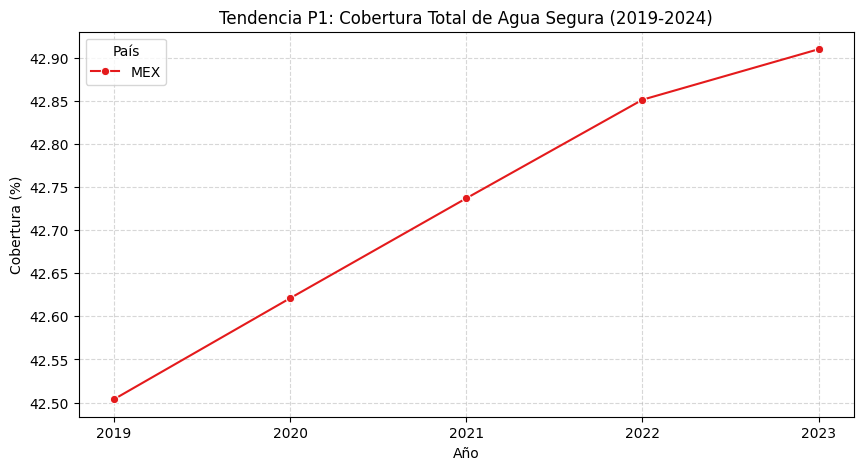

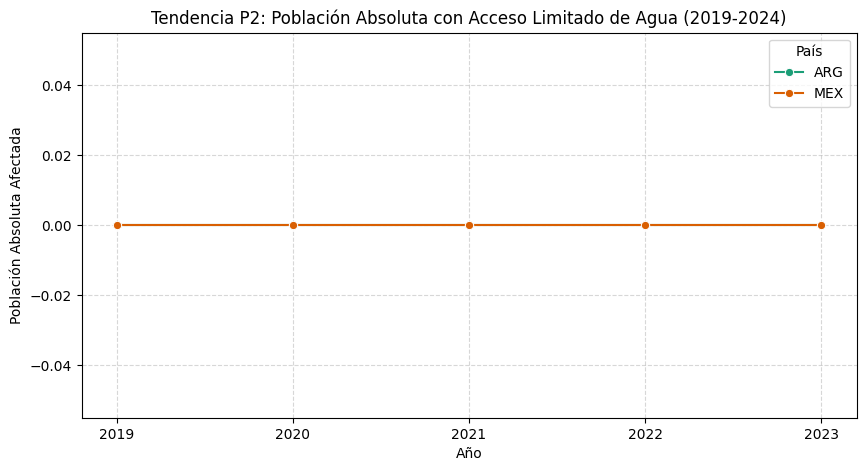

In [4]:
# VISUALIZACIÓN DE TENDENCIAS


# Tendencia P1: Cobertura de Agua Segura (Safely managed) 
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_water_safe,
    x='year',
    y='P1_Agua_Segura_Pct',
    hue='country_iso3',
    marker='o',
    palette='Set1'
)
plt.title('Tendencia P1: Cobertura Total de Agua Segura (2019-2024)')
plt.xlabel('Año')
plt.ylabel('Cobertura (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='País')
plt.xticks(df_water_safe['year'].unique())
plt.show()


# Tendencia P2: Población Absoluta con Servicio Limitado de Agua 
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_p2_trend,
    x='year',
    y='P2_Pob_Lim_Agua_Abs',
    hue='country_iso3',
    marker='o',
    palette='Dark2'
)
plt.title('Tendencia P2: Población Absoluta con Acceso Limitado de Agua (2019-2024)')
plt.xlabel('Año')
plt.ylabel('Población Absoluta Afectada')
# Formateo para números grandes
plt.ticklabel_format(style='plain', axis='y') 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='País')
plt.xticks(df_p2_trend['year'].unique())
plt.show()

In [5]:
print("DataFrame de Tendencia P2:")
print(df_p2_trend)

DataFrame de Tendencia P2:
  country_iso3  year  P2_Pob_Lim_Agua_Abs
0          ARG  2019                  0.0
1          ARG  2020                  0.0
2          ARG  2021                  0.0
3          ARG  2022                  0.0
4          ARG  2023                  0.0
5          MEX  2019                  0.0
6          MEX  2020                  0.0
7          MEX  2021                  0.0
8          MEX  2022                  0.0
9          MEX  2023                  0.0


In [6]:
# Crear un DataFrame booleano (True si es nulo)
df_null_bool = df_base.isnull()

# Agrupar por año y sumar (True=1, False=0) para obtener el conteo de nulos por columna, por año
df_null_count_by_year = df_null_bool.groupby('year').sum()

print("\n--- Conteo de Nulos Agregado por Año ---")
print(df_null_count_by_year)


--- Conteo de Nulos Agregado por Año ---
       country_iso3  residence_type  service_type  service_level  \
year                                                               
False             0               0             0              0   

       coverage_pct  population  gdp_per_capita_usd_current  \
year                                                          
False             0           0                           0   

       poverty_headcount  under5_mortality_per_1000  precipitation_sum_mm  
year                                                                       
False                 96                          0                     0  



--- Visualización de Nulos (Matriz) ---


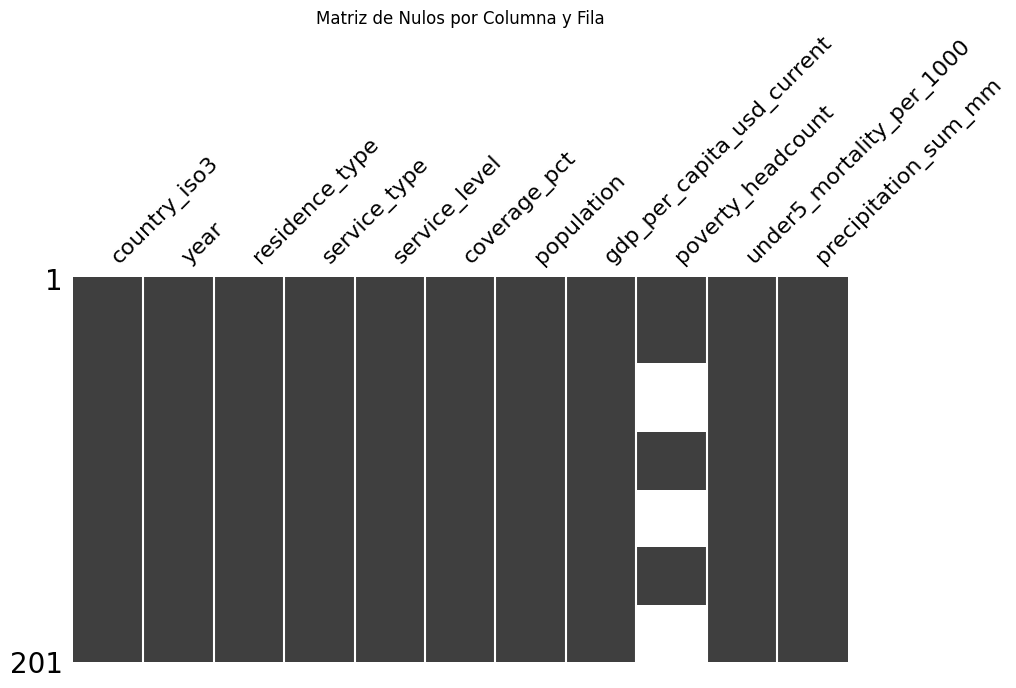


--- Porcentaje de Datos Existentes por Columna ---


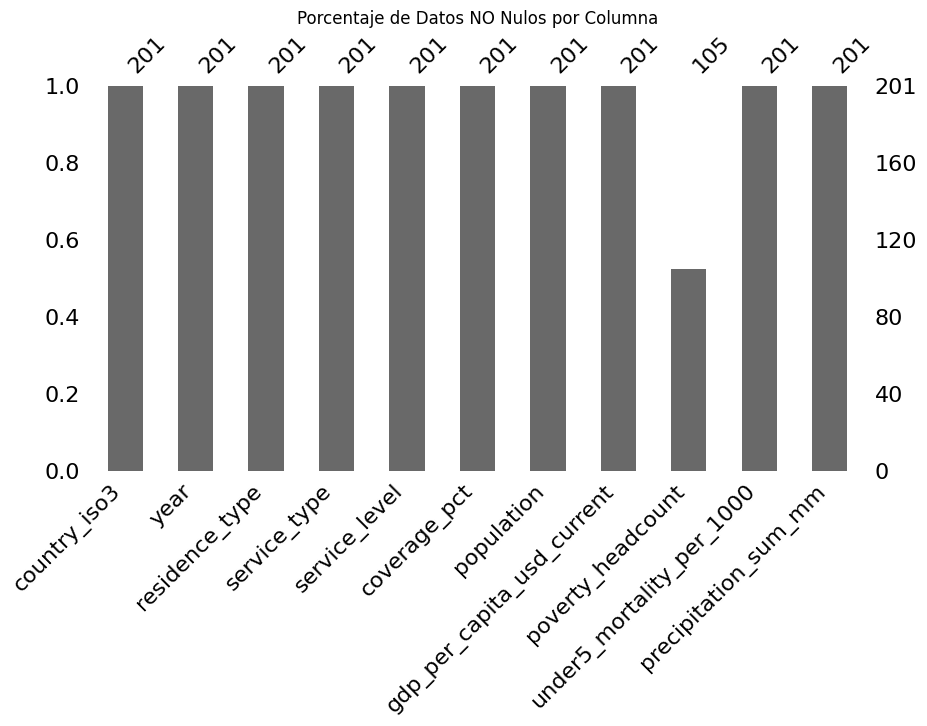

In [7]:
import missingno as msno 

# Gráfico de matriz: Visualiza la densidad de datos por fila (muestra dónde faltan datos)
print("\n--- Visualización de Nulos (Matriz) ---")
msno.matrix(df_base.sort_values(by=['country_iso3', 'year']), figsize=(10, 5), sparkline=False)
plt.title('Matriz de Nulos por Columna y Fila')
plt.show()

# Gráfico de barras: Muestra el porcentaje de datos existentes por columna 
print("\n--- Porcentaje de Datos Existentes por Columna ---")
msno.bar(df_base, figsize=(10, 5))
plt.title('Porcentaje de Datos NO Nulos por Columna')
plt.show()

In [8]:
# Estadísticas descriptivas de variables críticas
print("--- Estadísticas Descriptivas (Variables Clave) ---")
print(df_base[['coverage_pct', 'gdp_per_capita_usd_current', 'poverty_headcount', 'precipitation_sum_mm']].describe().T)

--- Estadísticas Descriptivas (Variables Clave) ---
                            count          mean          std          min  \
coverage_pct                201.0     27.191069    36.826028     0.000000   
gdp_per_capita_usd_current  201.0  11049.684526  1797.616447  8535.599380   
poverty_headcount           105.0      2.554286     1.175555     1.200000   
precipitation_sum_mm        201.0    875.779750    90.997162   753.441948   

                                     25%           50%           75%  \
coverage_pct                    0.059930      2.743790     52.471160   
gdp_per_capita_usd_current  10314.050673  10369.555359  11402.141037   
poverty_headcount               1.400000      2.300000      4.300000   
precipitation_sum_mm          754.662245    865.540894    966.954096   

                                     max  
coverage_pct                  100.000000  
gdp_per_capita_usd_current  14187.482725  
poverty_headcount               4.300000  
precipitation_sum_mm         

In [9]:
# Pivoteo para comparar la cobertura de agua segura (Safely managed)
df_residence_pivot = df_base[
    (df_base['service_type'] == 'Drinking water') & 
    (df_base['service_level'] == 'Safely managed service')
].pivot_table(
    index=['country_iso3', 'year'],
    columns='residence_type',
    values='coverage_pct'
)

print("\n--- Cobertura de Agua Segura (Urbano vs. Rural) ---")
print(df_residence_pivot)


--- Cobertura de Agua Segura (Urbano vs. Rural) ---
residence_type        total
country_iso3 year          
MEX          2019  42.50394
             2020  42.62107
             2021  42.73688
             2022  42.85114
             2023  42.90972


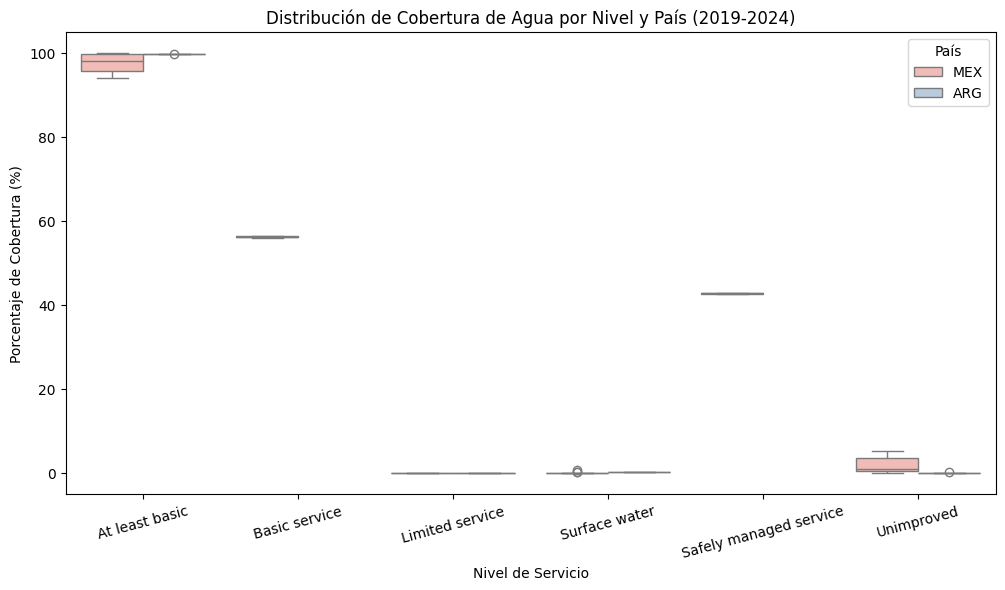

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de la Cobertura Hídrica por Nivel de Servicio 
plt.figure(figsize=(12, 6))
df_temp = df_base[df_base['service_type'] == 'Drinking water']
sns.boxplot(
    data=df_temp,
    x='service_level',
    y='coverage_pct',
    hue='country_iso3',
    palette='Pastel1'
)
plt.title('Distribución de Cobertura de Agua por Nivel y País (2019-2024)')
plt.xlabel('Nivel de Servicio')
plt.ylabel('Porcentaje de Cobertura (%)')
plt.xticks(rotation=15)
plt.legend(title='País')
plt.show()

In [11]:
# Filtramos solo los datos de Argentina para Agua Potable
df_arg_debug = df_base[
    (df_base['country_iso3'] == 'ARG') & 
    (df_base['service_type'] == 'Drinking water')
]

# Vemos las estadísticas por nivel de servicio
print("--- Estadísticas de Cobertura de Agua: Argentina (2019-2024) ---")
# El describe() nos mostrará el conteo (count), media (mean) y desviación (std)
print(df_arg_debug.groupby('service_level')['coverage_pct'].describe())

--- Estadísticas de Cobertura de Agua: Argentina (2019-2024) ---
                 count       mean       std       min       25%       50%  \
service_level                                                               
At least basic     5.0  99.806192  0.024861  99.76172  99.81731  99.81731   
Limited service    5.0   0.000000  0.000000   0.00000   0.00000   0.00000   
Surface water      5.0   0.118570  0.000000   0.11857   0.11857   0.11857   
Unimproved         5.0   0.075238  0.024861   0.06412   0.06412   0.06412   

                      75%       max  
service_level                        
At least basic   99.81731  99.81731  
Limited service   0.00000   0.00000  
Surface water     0.11857   0.11857  
Unimproved        0.06412   0.11971  


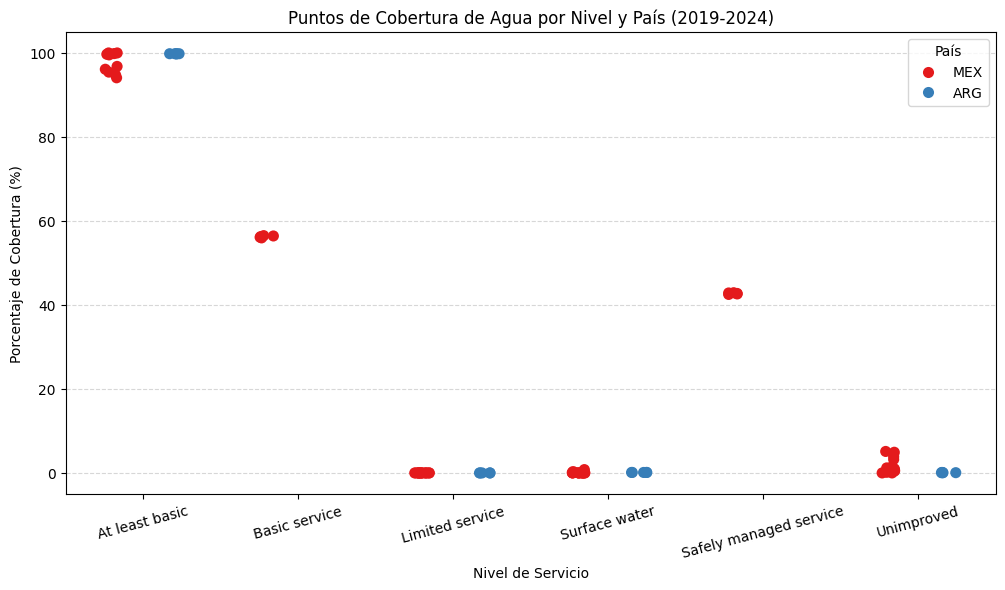

In [12]:
plt.figure(figsize=(12, 6))

sns.stripplot(
    data=df_temp,
    x='service_level',
    y='coverage_pct',
    hue='country_iso3',
    dodge=True, 
    palette='Set1',
    s=8 
)

plt.title('Puntos de Cobertura de Agua por Nivel y País (2019-2024)')
plt.xlabel('Nivel de Servicio')
plt.ylabel('Porcentaje de Cobertura (%)')
plt.xticks(rotation=15)
plt.legend(title='País')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

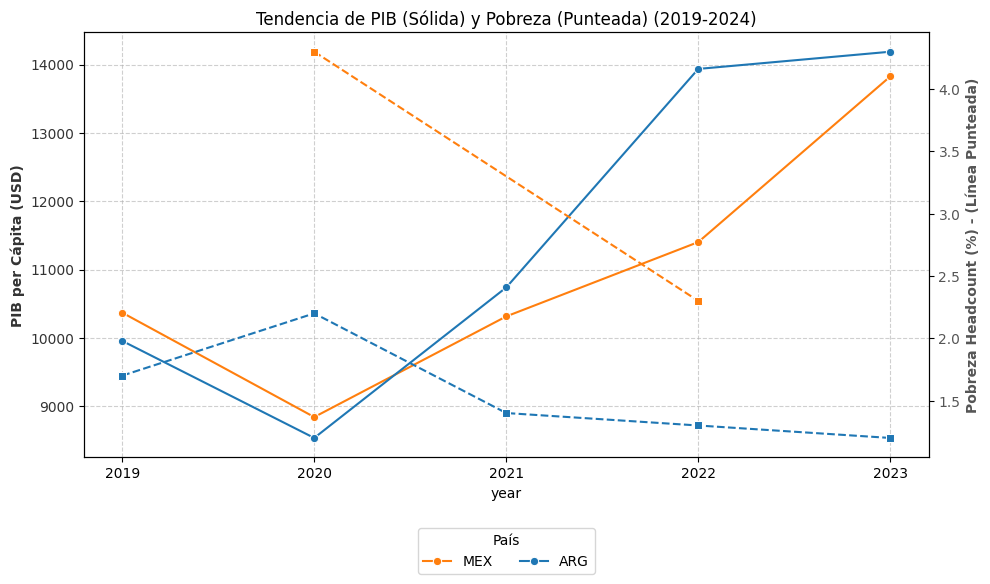

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

colores_paises = {'ARG': '#1f77b4', 'MEX': '#ff7f0e'} # Azul y Naranja estándar

df_econ = df_base[['country_iso3', 'year', 'gdp_per_capita_usd_current', 'poverty_headcount']].drop_duplicates()

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- GRÁFICO 1: PIB (Eje Izquierdo) - LÍNEA SÓLIDA ---
sns.lineplot(
    data=df_econ, 
    x='year', 
    y='gdp_per_capita_usd_current', 
    hue='country_iso3', 
    ax=ax1, 
    marker='o', 
    palette=colores_paises,
    legend=True
)

ax1.set_ylabel('PIB per Cápita (USD)', color='#333333', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#333333')
ax1.grid(True, linestyle='--', alpha=0.6)

# --- GRÁFICO 2: POBREZA (Eje Derecho)
ax2 = ax1.twinx()
sns.lineplot(
    data=df_econ, 
    x='year', 
    y='poverty_headcount', 
    hue='country_iso3', 
    ax=ax2, 
    marker='s', 
    linestyle='--',
    palette=colores_paises,
    legend=False
)

ax2.set_ylabel('Pobreza Headcount (%) - (Línea Punteada)', color='#555555', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#555555')

plt.title('Tendencia de PIB (Sólida) y Pobreza (Punteada) (2019-2024)')
plt.xticks(df_econ['year'].unique())

sns.move_legend(ax1, "upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, title='País')

plt.tight_layout()
plt.show()

In [ ]:
# Verificamos qué datos existen para México desde 2021 en adelante
print("--- Datos de México (2021-2024) ---")
cols_check = ['year', 'gdp_per_capita_usd_current', 'poverty_headcount']
df_mx_check = df_base[df_base['country_iso3'] == 'MEX'][cols_check].drop_duplicates().sort_values('year')

print(df_mx_check)

--- Datos de México (2021-2024) ---
     year  gdp_per_capita_usd_current  poverty_headcount
0    2019                10369.555359                NaN
36   2020                 8841.270751                4.3
66   2021                10314.050673                NaN
96   2022                11402.141037                2.3
126  2023                13826.130657                NaN


: 